# <font color=navy>Import necessary libraries</font>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Import Sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix,accuracy_score, fbeta_score

# Import Tensorflow
import tensorflow as tf
from tensorflow import keras

#Import Keras API
from keras.models import Sequential, load_model       
from keras.layers import Dense, Activation
import keras.backend as K
from keras.optimizers import adam
from keras.callbacks import History 

Using TensorFlow backend.


# <font color=navy>Data Preparation</font>

## Import Dataset and check distribution

In [2]:
df = pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/creditcard-training set v2.csv')
df = df.rename(columns={ df.columns[2]: "Fraud" })

#check the distribution
# for row in df.head():
#     fig=plt.figure(figsize=(17,10))
#     df.hist(column=row)
#     plt.xlabel(row,fontsize=15)
#     plt.ylabel("Frequency",fontsize=15)


## Drop unwanted rows and normalize data

In [3]:
# drop rows which has null values
df = df.dropna()

#drop feature 23 since it is meaningless in our analysis
df = df.drop(['Feature 23'], axis=1)

# Splitting our X and Y variables
Y = df.Fraud
Y = Y.values.reshape(Y.shape[0],1)

df = df.drop('Fraud', 1)
X = df.values

#Normalize our data
sc = StandardScaler()
X = sc.fit_transform(X)

## Split into training and testing set, oversampling of the minority class

In [4]:
def Oversample(X_train,Y_train,print_output=False):
    
    #Convert back to dataframe for random oversampling
    Train_set = np.concatenate((X_train, Y_train), axis=1)
    df = pd.DataFrame.from_records(Train_set)

    # Class count
    count_class_0, count_class_1 = df.iloc[:,30].value_counts()

    # Divide by class
    df_class_0 = df[df.iloc[:,30] == 0]
    df_class_1 = df[df.iloc[:,30] == 1]
    
    #Oversample the minority class and joining it back to original dataframe
    df_class_1_over = df_class_1.sample(count_class_0, replace=True)
    df = pd.concat([df_class_0, df_class_1_over], axis=0)

    #Shuffle rows
    df.sample(frac=1)
    
    #Splitting data back into X and Y variables
    Y_train = df.iloc[:,30].values
    X_train = df.iloc[:,0:30].values
    
    if print_output == True:
        
        #Print number of rows by class
        print('Random over-sampling:')
        print(df.iloc[:,30].value_counts())
    
    return X_train, Y_train

#Split data into train and test set (80 to 20)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

#Oversampling of our training set
X_train, Y_train = Oversample(X_train,Y_train)

# <font color=navy>Building and Training the Model </font>

## Defining the Neural Network Using Keras API

In [5]:
#Create a NN with 3 hidden layers using relu activation functions. 
#Output layer will use sigmoid function
model = Sequential()
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [6]:
# Compile the model with appropriate Loss function
model.compile(optimizer = adam(), 
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

## Defining functions before training the model

In [7]:
#Converts the model's output from probability into classes 1 or 0
def Convert_prob_to_class(Y_test_hat):
    
    Y_test_hat[Y_test_hat > 0.5] = 1
    Y_test_hat[Y_test_hat < 0.5] = 0

#Plot the ROC graph
def PlotROC(y_test,pred):
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return roc_auc

#Plot the loss history graph
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
#Printing the metrics and graphs of the model
def PrintStats(y_test, pred, history= None, output_print=False):
    
    f1Score = round(f1_score(y_test, pred), 2)
    recallScore = round(recall_score(y_test, pred), 2)
    precscore = round(precision_score(y_test, pred), 2)
    accScore = round(accuracy_score(y_test, pred), 2)
    beta = 4
    fbetaScore = round((1+beta) * (precscore * recallScore) / ((beta * precscore) + recallScore),2)
    
    #plot loss curve
    if history is not None:
        plot_history(history)
    
    #roc curve
    auc = PlotROC(y_test,pred)
    
    print("Accuracy for Model : {acc_score}".format(acc_score = accScore))
    print("Precision for Model : {prec_score}".format(prec_score = precscore))
    print("Sensitivity/Recall for Model : {recall_score}".format(recall_score = recallScore))
    print("F1 Score for Model : {f1_score}".format(f1_score = f1Score))
    print("F-Beta Score for Model : {fbeta_score}".format(fbeta_score = fbetaScore))
    
    output = [accScore,precscore,recallScore,f1Score, fbetaScore,auc]
    
    if output_print:
        return output

## Training the model (Alternatively, jump to loading of trained model)

In [8]:
#Train model
epochs = 12
batch_size = 72

history = model.fit(X_train, Y_train, 
                    validation_data = (X_test,Y_test), 
                    epochs = epochs,
                    batch_size = batch_size)

Train on 363754 samples, validate on 45553 samples
Epoch 1/12
363754/363754 [==============================] - 133s 365us/step - loss: 0.0404 - acc: 0.9944 - val_loss: 0.0099 - val_acc: 0.9983
Epoch 2/12
363754/363754 [==============================] - 131s 361us/step - loss: 0.0332 - acc: 0.9973 - val_loss: 0.0087 - val_acc: 0.9987
Epoch 3/12
363754/363754 [==============================] - 138s 380us/step - loss: 0.0346 - acc: 0.9972 - val_loss: 0.0076 - val_acc: 0.9991
Epoch 4/12
363754/363754 [==============================] - 177s 486us/step - loss: 0.0313 - acc: 0.9977 - val_loss: 0.0076 - val_acc: 0.9993
Epoch 5/12
363754/363754 [==============================] - 178s 488us/step - loss: 0.0310 - acc: 0.9978 - val_loss: 0.0087 - val_acc: 0.9993
Epoch 6/12
363754/363754 [==============================] - 174s 479us/step - loss: 0.0326 - acc: 0.9977 - val_loss: 0.0196 - val_acc: 0.9980
Epoch 7/12
363754/363754 [==============================] - 173s 475us/step - loss: 0.0302 - acc:

## Saving the trained model into HDF5 File

In [9]:
file_name = 'Saved_Neuralnetwork'

model.save(file_name)

## Loading the trained model from HDF5 File

In [10]:
file_name = 'Saved_Neuralnetwork'

model = load_model(file_name)

## Testing the data on the trained model

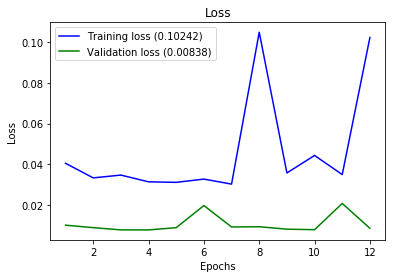

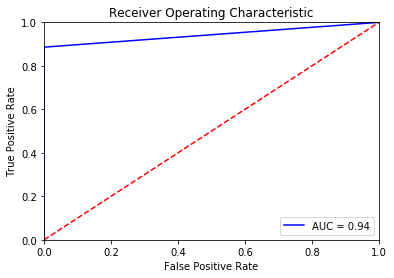

Accuracy for Model : 1.0
Precision for Model : 0.79
Sensitivity/Recall for Model : 0.89
F1 Score for Model : 0.83
F-Beta Score for Model : 0.87


In [11]:
#Run forward prop to get predicted values
Y_test_hat = model.predict(X_test)
Convert_prob_to_class(Y_test_hat)

#If model is loaded from file, we will not have any history logs
try:
    history
except NameError:
    history = None

#Print metrics and graphs
PrintStats(Y_test,Y_test_hat,history)

# <font color=navy>Cross Validating the Model </font>

## K-fold Cross Validation

Epoch 1/12
378974/378974 [==============================] - 180s 476us/step - loss: 0.2086 - acc: 0.9868
Epoch 2/12
378974/378974 [==============================] - 179s 472us/step - loss: 0.1480 - acc: 0.9907
Epoch 3/12
378974/378974 [==============================] - 178s 469us/step - loss: 0.1285 - acc: 0.9919
Epoch 4/12
378974/378974 [==============================] - 182s 479us/step - loss: 0.1171 - acc: 0.9926
Epoch 5/12
378974/378974 [==============================] - 136s 360us/step - loss: 0.1204 - acc: 0.9925
Epoch 6/12
378974/378974 [==============================] - 136s 358us/step - loss: 0.1319 - acc: 0.9917
Epoch 7/12
378974/378974 [==============================] - 136s 359us/step - loss: 0.1322 - acc: 0.9917
Epoch 8/12
378974/378974 [==============================] - 138s 365us/step - loss: 0.1392 - acc: 0.9913
Epoch 9/12
378974/378974 [==============================] - 137s 362us/step - loss: 0.1888 - acc: 0.9882
Epoch 10/12
378974/378974 [============================

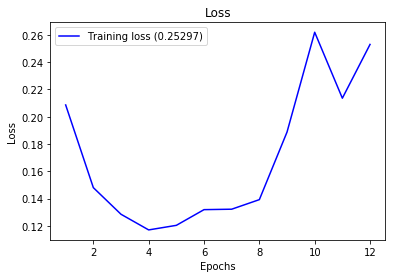

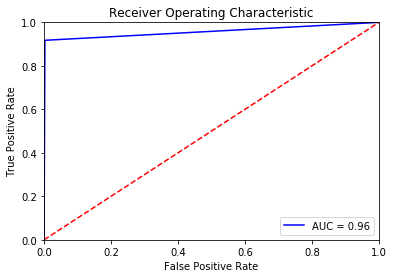

Accuracy for Model : 1.0
Precision for Model : 0.49
Sensitivity/Recall for Model : 0.92
F1 Score for Model : 0.64
F-Beta Score for Model : 0.78
Epoch 1/12
378942/378942 [==============================] - 136s 360us/step - loss: 0.1504 - acc: 0.9905
Epoch 2/12
378942/378942 [==============================] - 136s 359us/step - loss: 0.1580 - acc: 0.9902
Epoch 3/12
378942/378942 [==============================] - 135s 357us/step - loss: 0.1721 - acc: 0.9893
Epoch 4/12
378942/378942 [==============================] - 136s 358us/step - loss: 0.1719 - acc: 0.9893
Epoch 5/12
378942/378942 [==============================] - 138s 364us/step - loss: 0.2163 - acc: 0.9865
Epoch 6/12
378942/378942 [==============================] - 135s 356us/step - loss: 0.1727 - acc: 0.9893
Epoch 7/12
378942/378942 [==============================] - 136s 358us/step - loss: 0.1753 - acc: 0.9891
Epoch 8/12
378942/378942 [==============================] - 134s 354us/step - loss: 0.1323 - acc: 0.9917
Epoch 9/12
37894

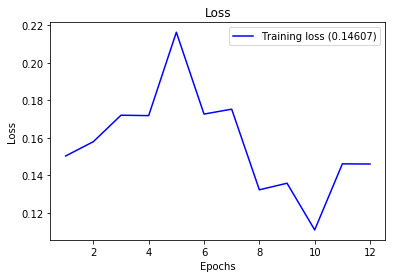

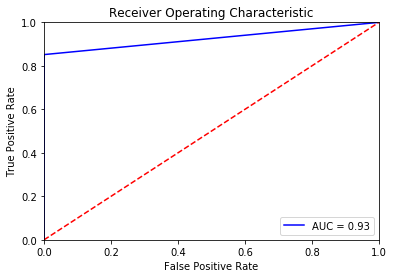

Accuracy for Model : 1.0
Precision for Model : 0.8
Sensitivity/Recall for Model : 0.85
F1 Score for Model : 0.83
F-Beta Score for Model : 0.84
Epoch 1/12
378896/378896 [==============================] - 137s 361us/step - loss: 0.1268 - acc: 0.9920
Epoch 2/12
378896/378896 [==============================] - 136s 359us/step - loss: 0.1952 - acc: 0.9878
Epoch 3/12
378896/378896 [==============================] - 137s 362us/step - loss: 0.2048 - acc: 0.9873
Epoch 4/12
378896/378896 [==============================] - 136s 359us/step - loss: 0.1428 - acc: 0.9911
Epoch 5/12
378896/378896 [==============================] - 136s 358us/step - loss: 0.1363 - acc: 0.9914
Epoch 6/12
378896/378896 [==============================] - 136s 358us/step - loss: 0.1107 - acc: 0.9931
Epoch 7/12
378896/378896 [==============================] - 139s 366us/step - loss: 0.1432 - acc: 0.9911
Epoch 8/12
378896/378896 [==============================] - 136s 360us/step - loss: 0.1573 - acc: 0.9902
Epoch 9/12
378896

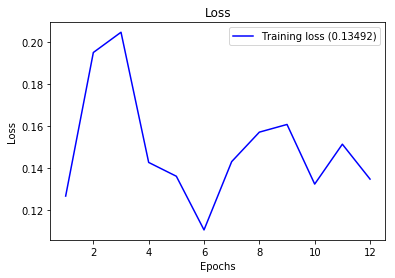

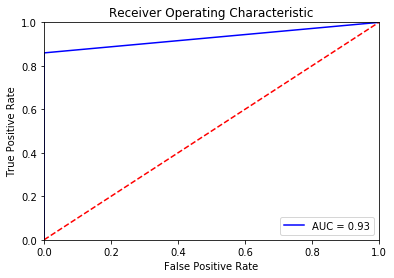

Accuracy for Model : 1.0
Precision for Model : 0.91
Sensitivity/Recall for Model : 0.86
F1 Score for Model : 0.88
F-Beta Score for Model : 0.87
Epoch 1/12
378954/378954 [==============================] - 136s 360us/step - loss: 0.2921 - acc: 0.9818
Epoch 2/12
378954/378954 [==============================] - 136s 360us/step - loss: 0.2202 - acc: 0.9863
Epoch 3/12
378954/378954 [==============================] - 136s 359us/step - loss: 0.2774 - acc: 0.9827
Epoch 4/12
378954/378954 [==============================] - 136s 359us/step - loss: 0.3480 - acc: 0.9784
Epoch 5/12
378954/378954 [==============================] - 138s 364us/step - loss: 0.3875 - acc: 0.9760
Epoch 6/12
378954/378954 [==============================] - 137s 362us/step - loss: 0.4088 - acc: 0.9746
Epoch 7/12
378954/378954 [==============================] - 142s 375us/step - loss: 0.4088 - acc: 0.9746
Epoch 8/12
378954/378954 [==============================] - 143s 378us/step - loss: 0.4088 - acc: 0.9746
Epoch 9/12
37895

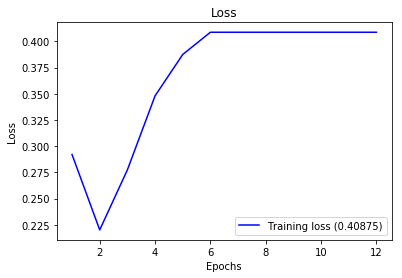

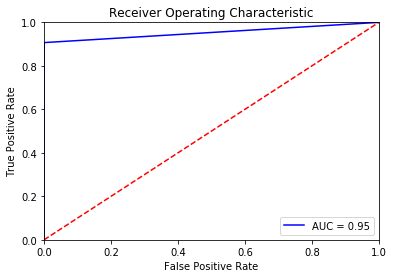

Accuracy for Model : 1.0
Precision for Model : 0.88
Sensitivity/Recall for Model : 0.91
F1 Score for Model : 0.89
F-Beta Score for Model : 0.9
Epoch 1/12
378870/378870 [==============================] - 145s 382us/step - loss: 0.2452 - acc: 0.9847
Epoch 2/12
378870/378870 [==============================] - 144s 379us/step - loss: 0.1796 - acc: 0.9888
Epoch 3/12
378870/378870 [==============================] - 138s 364us/step - loss: 0.1785 - acc: 0.9889
Epoch 4/12
378870/378870 [==============================] - 136s 360us/step - loss: 0.1679 - acc: 0.9896
Epoch 5/12
378870/378870 [==============================] - 138s 365us/step - loss: 0.1790 - acc: 0.9889
Epoch 6/12
378870/378870 [==============================] - 138s 365us/step - loss: 0.1972 - acc: 0.9877
Epoch 7/12
378870/378870 [==============================] - 137s 361us/step - loss: 0.1547 - acc: 0.9904
Epoch 8/12
378870/378870 [==============================] - 138s 363us/step - loss: 0.2497 - acc: 0.9845
Epoch 9/12
378870

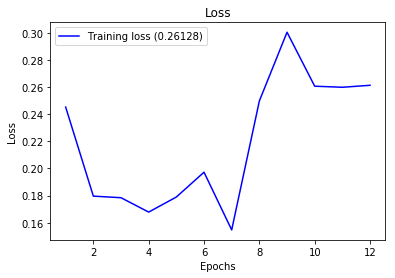

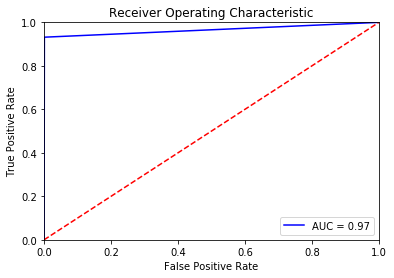

Accuracy for Model : 1.0
Precision for Model : 0.53
Sensitivity/Recall for Model : 0.93
F1 Score for Model : 0.68
F-Beta Score for Model : 0.81
Epoch 1/12
378874/378874 [==============================] - 137s 361us/step - loss: 0.3934 - acc: 0.9756
Epoch 2/12
378874/378874 [==============================] - 136s 359us/step - loss: 0.4980 - acc: 0.9691
Epoch 3/12
378874/378874 [==============================] - 137s 361us/step - loss: 0.4363 - acc: 0.9729
Epoch 4/12
378874/378874 [==============================] - 137s 361us/step - loss: 0.2570 - acc: 0.9840
Epoch 5/12
378874/378874 [==============================] - 135s 357us/step - loss: 0.2494 - acc: 0.9845
Epoch 6/12
378874/378874 [==============================] - 136s 358us/step - loss: 0.3001 - acc: 0.9814
Epoch 7/12
378874/378874 [==============================] - 138s 363us/step - loss: 0.2838 - acc: 0.9824
Epoch 8/12
378874/378874 [==============================] - 138s 365us/step - loss: 0.2929 - acc: 0.9818
Epoch 9/12
37887

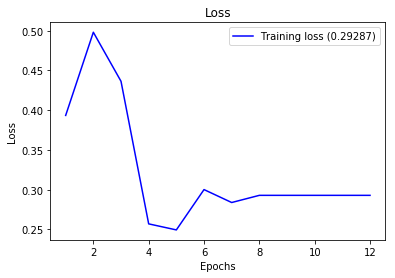

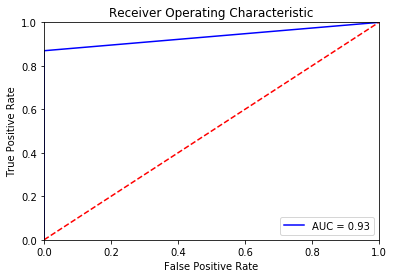

Accuracy for Model : 1.0
Precision for Model : 0.89
Sensitivity/Recall for Model : 0.87
F1 Score for Model : 0.88
F-Beta Score for Model : 0.87

Summary metrics:
Accuracy for Model : 1.0
Precision for Model : 0.75
Sensitivity/Recall for Model : 0.89
F1 Score for Model : 0.8
F-Beta Score for Model : 0.85
AUC for Model : 0.9444170549997278


In [12]:
#Define parameters for k-fold cross val
n_folds = 6
kf = KFold(n_folds)
Metric_array = np.zeros(6)

epochs = 12
batch_size = 72
counter = 1

#Start k-fold cross validation 
for train_index, test_index in kf.split(X):
    
    #Split into training and testing set
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    #Oversampling of training set ONLY
    X_train, Y_train = Oversample(X_train,Y_train)
    
    #run the model
    history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs)
    
    #Run forward prop to get predicted values
    Y_test_hat = model.predict(X_test)
    Convert_prob_to_class(Y_test_hat)
    
    print('\nMetrics for fold number: ' + str(counter))
    counter += 1
    
    #Print metrics and store in numpy array to average after end of cv 
    Metric_array += PrintStats(Y_test,Y_test_hat,history,True)
    
#Averaging of metrics across folds    
Metric_array /= n_folds

print('\nSummary metrics:')
print("Accuracy for Model : {acc_score}".format(acc_score = np.around(Metric_array[0],decimals = 2)))
print("Precision for Model : {prec_score}".format(prec_score = np.around(Metric_array[1],decimals = 2)))
print("Sensitivity/Recall for Model : {recall_score}".format(recall_score = np.around(Metric_array[2],decimals = 2)))
print("F1 Score for Model : {f1_score}".format(f1_score = np.around(Metric_array[3],decimals = 2)))
print("F-Beta Score for Model : {f1_score}".format(f1_score = np.around(Metric_array[4],decimals = 2)))
print("AUC for Model : {auc}".format(auc = Metric_array[5]))